In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from preprocessing.sliding_window import create_windowed_dataset

### Data loading

In [3]:
data_path = '/home/hariub/data/HAR/processed/clean_daphnet_data.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,Time,Ankle_acc_x,Ankle_acc_y,Ankle_acc_z,Thigh_acc_x,Thigh_acc_y,Thigh_acc_z,Trunk_acc_x,Trunk_acc_y,Trunk_acc_z,Label,Subject,Run
0,15.0,70.0,39.0,-970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,31.0,70.0,39.0,-970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,46.0,60.0,49.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,62.0,60.0,49.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,78.0,50.0,39.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [5]:
FEATURES = ['Ankle_acc_x', 'Ankle_acc_y', 'Ankle_acc_z', 'Thigh_acc_x','Thigh_acc_y', 'Thigh_acc_z', 'Trunk_acc_x', 'Trunk_acc_y','Trunk_acc_z']
LABEL = ['Label']

In [6]:
df = df.fillna(0)
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

df = df[df['Label'] != 2]

In [7]:
hyperparameters = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)

metadata = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)['daphnet_preprocess']

In [8]:
train_df = df[(df['Subject'] != 2) & (df['Subject'] != 9)]
test_df = df[df['Subject'] == 2]
val_df = df[df['Subject'] == 9]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

# FEATURES = metadata['feature_list']

X_train, y_train = create_windowed_dataset(
    train_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(
    val_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(
    test_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

# X_train = X_train.reshape(
#     (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
# X_val = X_val.reshape(
#     (X_val.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
# X_test = X_test.reshape(
#     (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [9]:
print(X_train.shape)
print(y_train.shape)

(9296, 320, 9)
(9296, 2)


In [10]:
# y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=metadata['n_window'], axis=1)
# y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=metadata['n_window'], axis=1)
# y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=metadata['n_window'], axis=1)

In [11]:
# y_train_mid.shape

### Model

In [12]:
class AttentionWithContext(tf.keras.layers.Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False):
        super(AttentionWithContext, self).__init__()

        self.supports_masking = True
        self.return_attention = return_attention
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.u_regularizer = tf.keras.regularizers.get(u_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.u_constraint = tf.keras.constraints.get(u_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.tensordot(x, self.W,axes=1)

        if self.bias:
            uit += self.b

        uit = tf.keras.activations.tanh(uit)
        ait = tf.tensordot(uit, self.u,axes=1)

        a = tf.math.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, tf.keras.backend.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= tf.cast(tf.keras.backend.sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.keras.backend.floatx())

        a = tf.keras.backend.expand_dims(a)
        weighted_input = x * a
        result = tf.keras.backend.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            #TODO use TensorShape here, as done in the else statement.   I'm not sure
            # if this is returning a single tensor, or a list of two so leaving this undone for now.  Suspect this will
            # need to complete if using Sequential rather than Functional API
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return tf.TensorShape([input_shape[0].value,input_shape[-1].value])
        
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
    self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
    self.wv = tf.keras.layers.Dense(d_model,use_bias=True)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

class SensorAttention(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_size, dilation_rate):
        super(SensorAttention, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(n_filters, kernel_size=kernel_size, 
                                                      dilation_rate=dilation_rate, padding='same', activation='relu')
        self.conv_2 = tf.keras.layers.SeparableConv2D(n_filters, kernel_size=kernel_size, 
                                                      dilation_rate=dilation_rate*2, padding='same', activation='relu')
        self.conv_f = tf.keras.layers.Conv2D(1, kernel_size=1, padding='same')
        self.ln = tf.keras.layers.LayerNormalization()
    
    def call(self, x):
        x = self.ln(x)
        x1 = tf.expand_dims(x, axis=3)
        # print(x1.shape)
        x1 = self.conv_1(x1)
        # x1 = self.conv_2(x1)
        x1 = self.conv_f(x1)
        x1 = tf.keras.activations.softmax(x1, axis=2)
        x1 = tf.keras.layers.Reshape(x.shape[-2:])(x1)
        # print(x1.shape)
        #print(x1.numpy)
        return tf.math.multiply(x,x1), x1

In [13]:
def get_model(n_timesteps, n_features, n_outputs,_dff = 512,d_model=128,nh = 4,dropout_rate=0.2,use_pe=True):
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    si,_ = SensorAttention(n_filters=128, kernel_size =3, dilation_rate=2)(inputs)
    x = tf.keras.layers.Conv1D(d_model, 1, activation='relu')(si)
    if use_pe:
        x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
        x = PositionalEncoding(n_timesteps, d_model)(x)
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = EncoderLayer(d_model=d_model, num_heads=nh, dff=_dff, rate=dropout_rate) (x)
    x = EncoderLayer(d_model=d_model, num_heads=nh, dff=_dff, rate=dropout_rate) (x)
    #x = tf.keras.layers.Dense(128, activation='relu') (x)
    x = AttentionWithContext() (x)
    x = tf.keras.layers.Dense(n_outputs*4, activation='relu') (x)
    x = tf.keras.layers.Dropout(0.2) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

In [22]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
device_list = ['/gpu:'+str(i) for i in range(5, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = get_model(n_timesteps, n_features, n_outputs,d_model=256,_dff = 1024,nh =4,dropout_rate=0.2)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 9)]          0         
_________________________________________________________________
sensor_attention (SensorAtte ((None, 320, 9), (None, 3 1427      
_________________________________________________________________
conv1d (Conv1D)              (None, 320, 256)          2560      
_________________________________________________________________
tf_op_layer_Mul (TensorFlowO [(None, 320, 256)]        0         
_________________________________________________________________
positional_encoding (Positio (None, 320, 256)          0         
_________

In [23]:
verbose, epochs, batch_size = 1, 10, 128
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1, mode='max')
#mcp_save = ModelCheckpoint('test_3_best.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size*len(device_list),
              verbose=verbose, validation_split=0.1,
          callbacks=[reduce_lr_loss])

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 45 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 45 all-reduces with algorithm = nccl, num_packs = 1
22/22 [==============================] - 16s 728ms/step - loss: 0.6667 - accuracy: 0.5989 - val_loss: 0.4726 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - 13s 596ms/step - loss: 0.5372 - accuracy: 0.7260 - val_loss: 0.4377 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 3/10
22/22 [==============================] - 13s 596ms/step - loss: 0.4395 - accuracy: 0.7637 - val_loss: 0.4721 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 4/10
22/22 [==============================] - 13s 594ms/step - loss: 0.4039 - accuracy: 0.7704 - val_loss: 0.4128 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 5/10
22/22 [==============================] - 13s 596ms/step - loss: 0.3916 - accuracy: 0.8152 - val_loss: 0.4894 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 6/10
22/22 [==============================

In [31]:
model.fit(X_train, y_train, epochs=1, batch_size=batch_size*len(device_list),
              verbose=verbose, validation_split=0.1)

22/22 [==============================] - 13s 592ms/step - loss: 0.3164 - accuracy: 0.8456 - val_loss: 0.7581 - val_accuracy: 0.7602


In [32]:
pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [33]:
# labels_map = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',
#               11:'ascending stairs',12:'descending stairs',13:'vacuum cleaning',
#               14:'ironing', 18:'rope jumping'}
# class_names = list(labels_map.values())

In [34]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80       443
           1       0.80      0.88      0.84       490

    accuracy                           0.82       933
   macro avg       0.82      0.82      0.82       933
weighted avg       0.82      0.82      0.82       933



In [35]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80       443
           1       0.80      0.88      0.84       490

    accuracy                           0.82       933
   macro avg       0.82      0.82      0.82       933
weighted avg       0.82      0.82      0.82       933



In [36]:
# activity_map

<AxesSubplot:>

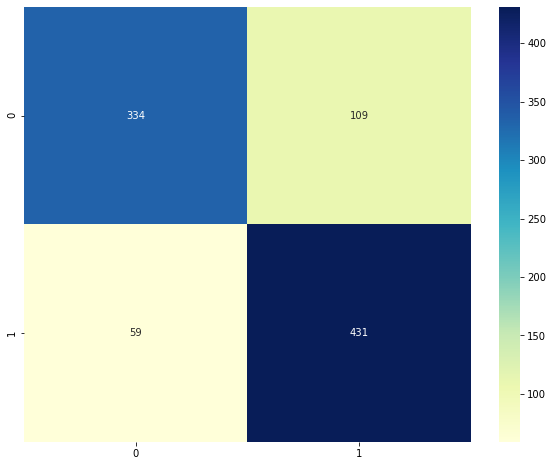

In [37]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [ ]:
confm = confusion_matrix(np.argmax(y_test_mid.reshape(-1, 2), axis=1), np.argmax(pred_mid.reshape(-1, 2), axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")